In [1]:
%matplotlib inline
import pandas as pd
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import os
import numpy as np

# stuff to deal with the words
import nltk
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt

In [2]:
# nltk might complain

# nltk.download('wordnet')
# nltk.download('punkt')

In [3]:
# read in the data
df = pd.read_json('./data/recipies.json')

In [4]:
df

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."
...,...,...,...
39769,29109,irish,"[light brown sugar, granulated sugar, butter, ..."
39770,11462,italian,"[KRAFT Zesty Italian Dressing, purple onion, b..."
39771,2238,irish,"[eggs, citrus fruit, raisins, sourdough starte..."
39772,41882,chinese,"[boneless chicken skinless thigh, minced garli..."


# Make a few simple EDA plots

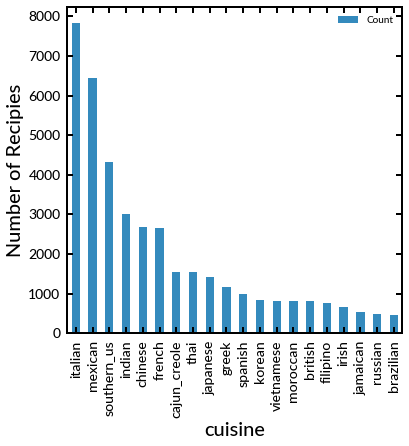

In [5]:
df_v = df.groupby(['cuisine'], as_index=False)['ingredients'].count()
df_v.rename(columns={'ingredients': 'Count'}, inplace=True)
df_v.sort_values(by='Count', ascending=False, inplace=True)
df_v.reset_index(drop=True,inplace=True)
df_v.head(20).plot.bar(x='cuisine', y='Count', figsize=(6,6))
plt.ylabel('Number of Recipies')
plt.savefig('01. eda.png')

# Try to deal with the text data

So the models aren't going to be able to deal with the textual data. We'll need to encode everything into numerical values so we can feed them into some sort of a model. 

The real issue is the ingredient list. It doesn't easily encode using something like a one-hot encoder. I did some googling, and people suggest using TF-IDF to encode the string. We'll see how that goes... 

In [6]:
# encode the cuisines into numerical values

encoder = preprocessing.LabelEncoder() #encoder for cuisine
cuisine_enc = encoder.fit_transform(df['cuisine'])

df['cuisine_enc'] = cuisine_enc

In [7]:
encoder.classes_

array(['brazilian', 'british', 'cajun_creole', 'chinese', 'filipino',
       'french', 'greek', 'indian', 'irish', 'italian', 'jamaican',
       'japanese', 'korean', 'mexican', 'moroccan', 'russian',
       'southern_us', 'spanish', 'thai', 'vietnamese'], dtype=object)

In [8]:
vectorizer = TfidfVectorizer(binary=True)

In [9]:
df['ingredients2'] = df['ingredients'].apply(','.join)

In [10]:
X = vectorizer.fit_transform(df['ingredients2'])

In [11]:
print(vectorizer.get_feature_names())

['00', '10', '100', '14', '15', '25', '33', '40', '43', '95', '96', 'abalone', 'abbamele', 'absinthe', 'abura', 'acai', 'accent', 'accompaniment', 'achiote', 'acid', 'acini', 'ackee', 'acorn', 'acting', 'activ', 'active', 'added', 'adobo', 'adzuki', 'agar', 'agave', 'age', 'aged', 'ahi', 'aioli', 'ajinomoto', 'ajwain', 'aka', 'alaskan', 'albacore', 'alcohol', 'ale', 'aleppo', 'alexia', 'alfalfa', 'alfredo', 'all', 'allspice', 'almond', 'almondmilk', 'almonds', 'aloe', 'alphabet', 'alum', 'amaranth', 'amarena', 'amaretti', 'amaretto', 'amba', 'amber', 'amberjack', 'amchur', 'america', 'american', 'aminos', 'ammonium', 'amontillado', 'ampalaya', 'an', 'anaheim', 'anasazi', 'ancho', 'anchovies', 'anchovy', 'and', 'andouille', 'anejo', 'angel', 'anglaise', 'angled', 'angostura', 'angus', 'anise', 'anisette', 'anjou', 'annatto', 'any', 'aonori', 'apple', 'apples', 'applesauce', 'applewood', 'apricot', 'apricots', 'aquavit', 'arak', 'arame', 'arbol', 'arborio', 'arctic', 'arepa', 'argo', 'ar

From looking at the feature names, there are a lot of repeated words or almost repeated words... like "bananas" and "banana". There also seem to be some misspellings, but I'm not sure how I am going to deal with that. 

After some googling... to remove the "bananas" and "banana" we need to "lemmatize" the words. 

I'd really like to lemmatize the words and then use the whole phrase as a feature. I dunno how to do that.


After some more googling... we are going to use `nltk` to do the lemmatizing.

# Lemmatize the words

In [12]:
l = [[' '.join([WordNetLemmatizer().lemmatize(w).lower() for w in words.split()]) for words in lists] for lists in df['ingredients']]

In [13]:
l[0]

['romaine lettuce',
 'black olive',
 'grape tomato',
 'garlic',
 'pepper',
 'purple onion',
 'seasoning',
 'garbanzo bean',
 'feta cheese crumbles']

In [14]:
df['ingredients_lemma'] = l

In [15]:
df

,id,cuisine,ingredients,cuisine_enc,ingredients2,ingredients_lemma
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",6,"romaine lettuce,black olives,grape tomatoes,ga...","[romaine lettuce, black olive, grape tomato, g..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",16,"plain flour,ground pepper,salt,tomatoes,ground...","[plain flour, ground pepper, salt, tomato, gro..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",4,"eggs,pepper,salt,mayonaise,cooking oil,green c...","[egg, pepper, salt, mayonaise, cooking oil, gr..."
3,22213,indian,"[water, vegetable oil, wheat, salt]",7,"water,vegetable oil,wheat,salt","[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...",7,"black pepper,shallots,cornflour,cayenne pepper...","[black pepper, shallot, cornflour, cayenne pep..."
...,...,...,...,...,...,...
39769,29109,irish,"[light brown sugar, granulated sugar, butter, ...",8,"light brown sugar,granulated sugar,butter,warm...","[light brown sugar, granulated sugar, butter, ..."
39770,11462,italian,"[KRAFT Zesty Italian Dressing, purple onion, b...",9,"KRAFT Zesty Italian Dressing,purple onion,broc...","[kraft zesty italian dressing, purple onion, b..."
39771,2238,irish,"[eggs, citrus fruit, raisins, sourdough starte...",8,"eggs,citrus fruit,raisins,sourdough starter,fl...","[egg, citrus fruit, raisin, sourdough starter,..."
39772,41882,chinese,"[boneless chicken skinless thigh, minced garli...",3,"boneless chicken skinless thigh,minced garlic,...","[boneless chicken skinless thigh, minced garli..."


# Train-Test Split

At this point we need to do some splitting. We only want to do the feature engineering on the training data. We'll then apply it to the testing data, but we don't want to make decisions with knowledge about the test data.

Would be nice to use sklearn but we'll do it outselves. 80% training 20% testing

In [16]:
mask = np.random.rand(len(df)) < 0.8
df_train = df[mask]
df_test = df[~mask]

# Feature Engineering. 

So there are a ton of different ingredients... We are going to focus on only a few to get us going. Let's focus on the ingredients that show up the most often. If it only appears 1-2 times, then it's not going to give us very much predictive power. 

In [17]:
# Feature engineering
print("Selecting ingredients for features...")
recipe = np.array(df_train['ingredients_lemma'].values)
ingredients_dict = {}
for i in range(0, len(recipe)):
    for word in recipe[i][:]:
        try:
            ingredients_dict[word] += 1
        except:
            ingredients_dict[word] = 1

Selecting ingredients for features...


In [18]:
ingredients_dict

{'plain flour': 125,
 'ground pepper': 313,
 'salt': 14497,
 'tomato': 2454,
 'ground black pepper': 3816,
 'thyme': 286,
 'egg': 2694,
 'green tomato': 82,
 'yellow corn meal': 267,
 'milk': 1792,
 'vegetable oil': 3509,
 'pepper': 3555,
 'mayonaise': 620,
 'cooking oil': 389,
 'green chilies': 612,
 'grilled chicken breast': 4,
 'garlic powder': 1150,
 'yellow onion': 956,
 'soy sauce': 2647,
 'butter': 3890,
 'chicken liver': 55,
 'water': 5975,
 'wheat': 23,
 'olive oil': 6365,
 'medium shrimp': 390,
 'garlic': 5898,
 'chopped cilantro': 650,
 'jalapeno chilies': 1396,
 'flat leaf parsley': 860,
 'skirt steak': 65,
 'white vinegar': 439,
 'sea salt': 758,
 'bay leaf': 1499,
 'chorizo sausage': 80,
 'sugar': 5173,
 'pistachio nut': 18,
 'white almond bark': 1,
 'flour': 1086,
 'vanilla extract': 1049,
 'almond extract': 145,
 'baking powder': 1414,
 'dried cranberry': 42,
 'chopped tomato': 234,
 'fresh basil': 916,
 'extra-virgin olive oil': 2215,
 'kosher salt': 2462,
 'low sodium

In [19]:
len(ingredients_dict)

6324

In [20]:
# order them from most frequent to less frequent
ingredients_dict1 = sorted(ingredients_dict.items(), key = lambda x:x[1], reverse=True)

In [21]:
ingredients_dict1 = dict(ingredients_dict1)

In [22]:
# select the max number of features, and the features that have at least N < num < M number of appearances.
maxFeatures = 1000
lim = [50, 15000]
selectedIngredients = [item for item in ingredients_dict if lim[0] <= ingredients_dict[item] <= lim[1]]
selectedIngredients = selectedIngredients[:maxFeatures]

In [23]:
selectedIngredients[:25]

['plain flour',
 'ground pepper',
 'salt',
 'tomato',
 'ground black pepper',
 'thyme',
 'egg',
 'green tomato',
 'yellow corn meal',
 'milk',
 'vegetable oil',
 'pepper',
 'mayonaise',
 'cooking oil',
 'green chilies',
 'garlic powder',
 'yellow onion',
 'soy sauce',
 'butter',
 'chicken liver',
 'water',
 'olive oil',
 'medium shrimp',
 'garlic',
 'chopped cilantro']

# Create the Feature Matrix... 

This is where we are building all the encoded features into our training and testing matrices.

In [24]:
def getFeatureArray(itemlist,featureList,featureArray):
    for item in itemlist:
        if item in featureList:
            featureArray[item] = 1
    return featureArray

def create_feature_matrix(df, selectedIngredients, numFeatures=None):
    print("Constructing feature matrix...")
    if not numFeatures:
        numFeatures = len(selectedIngredients)
    
    featureMatrix = np.zeros((len(df.index), numFeatures), dtype=int)

    # Construct a featureMatrix containing the feature info of all the entries in dataframe
    i = 0
    for index, row in df.iterrows():
        itemList = set(row['ingredients_lemma'])
        featureMatrix[i,:] = getFeatureArray(itemList, selectedIngredients, pd.Series(0, index=selectedIngredients))
        i += 1
    
    return featureMatrix

In [25]:
featureMatrix_train = create_feature_matrix(df_train, selectedIngredients)
featureMatrix_test = create_feature_matrix(df_test, selectedIngredients)

Constructing feature matrix...
Constructing feature matrix...


In [26]:
featureMatrix_train

array([[1, 1, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [27]:
featureMatrix_train.shape

(31817, 864)

# Train the model

Gonna use a random forst model because I like them and we have all these catagorical features

In [28]:
from sklearn.ensemble import RandomForestClassifier

In [29]:
forest = RandomForestClassifier(n_estimators=100)

model = forest.fit(featureMatrix_train, df_train.cuisine_enc.values.reshape(-1, 1))


/home/boada/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [30]:
predictions = model.predict(featureMatrix_test)

In [31]:
print(classification_report(df_test.cuisine_enc.values, predictions))

              precision    recall  f1-score   support

           0       0.68      0.35      0.46        91
           1       0.42      0.21      0.28       170
           2       0.76      0.65      0.70       315
           3       0.70      0.83      0.76       548
           4       0.60      0.40      0.48       147
           5       0.47      0.45      0.46       522
           6       0.75      0.50      0.60       230
           7       0.78      0.85      0.81       603
           8       0.49      0.24      0.32       144
           9       0.69      0.86      0.77      1553
          10       0.93      0.33      0.49       126
          11       0.68      0.56      0.62       290
          12       0.81      0.58      0.68       173
          13       0.80      0.89      0.84      1308
          14       0.72      0.54      0.62       147
          15       0.56      0.26      0.35        93
          16       0.56      0.70      0.62       794
          17       0.60    

In [38]:
%matplotlib notebook
from sklearn import metrics


<IPython.core.display.Javascript object>


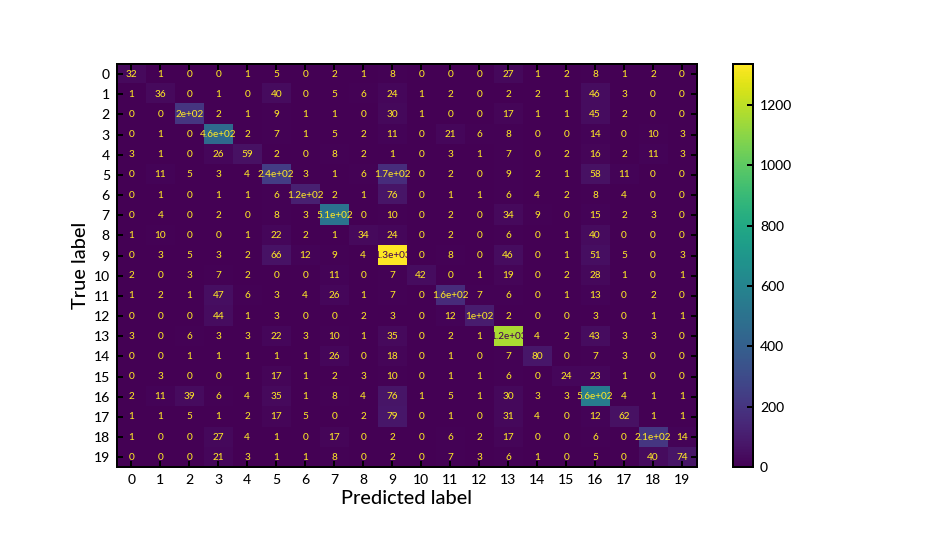

In [39]:
metrics.plot_confusion_matrix(model, featureMatrix_test, df_test.cuisine_enc.values)

In [ ]:
plt.savefig('01. confusion.png')

In [35]:
indx = np.argsort(model.feature_importances_)
for i, si in zip(model.feature_importances_[indx][::-1], np.asarray(selectedIngredients)[indx][::-1]):
    print(si, i)

grated parmesan cheese 0.017279661096383264
soy sauce 0.014352745053800915
olive oil 0.012210323733270271
garam masala 0.010893189162751253
fish sauce 0.010703089113042432
salt 0.010688835406193307
corn tortilla 0.009757040023214616
extra-virgin olive oil 0.0089912809057687
ground cumin 0.00883335154426385
water 0.008749526297894389
sesame oil 0.008736543535239782
flour tortilla 0.008548311333775059
salsa 0.008501257859059358
chili powder 0.008052749142240991
avocado 0.007931149394872342
sugar 0.007535844184965707
jalapeno chilies 0.006894563319120719
onion 0.006756173818709783
corn starch 0.006645689653090724
ground turmeric 0.006497040186642226
buttermilk 0.00645624584495742
cumin seed 0.006199574008259346
garlic 0.006137249741601883
black bean 0.006136041314882531
butter 0.006061824383362772
egg 0.005769990124322322
chopped cilantro fresh 0.005680687413418777
mirin 0.005674963964636638
pepper 0.005659993260178469
garlic clove 0.005585672244012923
all-purpose flour 0.0055275324149494

In [36]:
encoder.classes_[5]

'french'